Images Data Type: <class 'numpy.uint8'> (480, 64, 64, 3)
Labels Data Type: <class 'numpy.float64'> (480,)


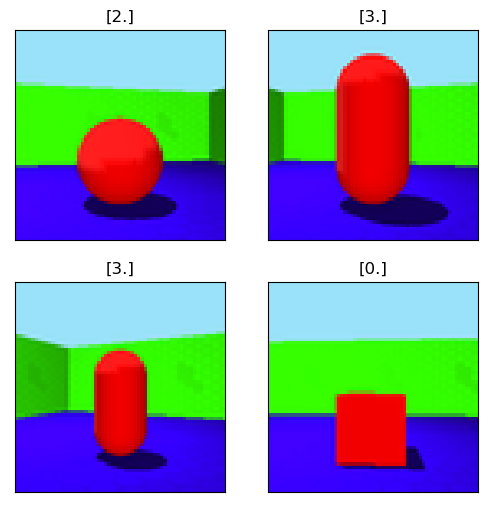

In [1]:
# Load python modules
import numpy as np, cv2, sys
from tqdm import tqdm
from matplotlib import pyplot as plt
np.set_printoptions(suppress=True)
# Load filtered image and label data sampled from 3dshapes_filtered.ipynb
images = np.load("3dshapesfiltered.npy")
labels = np.load("3dshapeslabel.npy")
# Define visualisation function from https://github.com/google-deepmind/3d-shapes
def show_images_grid(images, labels, num_samples, num_images=25, random=False):
    ncols = int(np.ceil(num_images**0.5))
    nrows = int(np.ceil(num_images / ncols))
    _, axes = plt.subplots(ncols, nrows, figsize=(nrows*3, ncols*3))
    axes = axes.flatten()
    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            if random:
                ax_i = np.random.choice(num_samples, 1)
                ax.imshow((images[int(ax_i[0])]/255.0).astype(np.float32), cmap='Greys_r', interpolation='nearest')
                ax.title.set_text(str(labels[ax_i]))
            else:
                ax.imshow((images[ax_i]/255.0).astype(np.float32), cmap='Greys_r', interpolation='nearest')
                ax.title.set_text(str(labels[ax_i]))
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')
# Sanity check loaded images
show_images_grid(images, labels, num_samples=480, num_images=4, random=True)
# Sanity check datatype
print("Images Data Type:", type(images[0][0][0][0]), images.shape)
print("Labels Data Type:", type(labels[0]), labels.shape)

Step 1: Process training data such that floor/wall/object saturations are equal on the region of $\left[\epsilon, 0.5\right]$.

  5%|▌         | 24/480 [00:00<00:06, 75.10it/s]

100%|██████████| 480/480 [00:06<00:00, 76.98it/s]


Train Images Data Type: <class 'numpy.uint8'> (60000, 64, 64, 3)
Train Labels Data Type: <class 'numpy.float64'> (60000,)


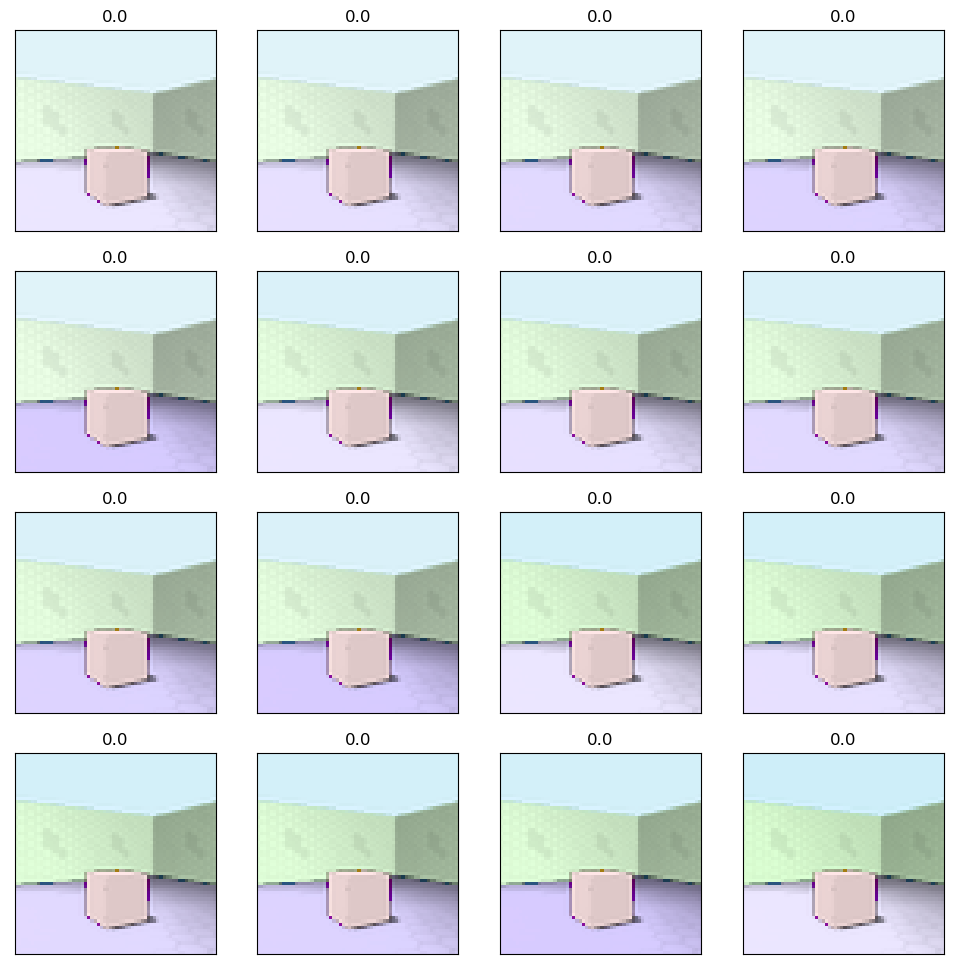

In [2]:
# Initialise number of base images
num_bases = len(images)
# Initialise fragmentation of saturation shift
num_shift = 5
# Training images and labels array
images_train = np.zeros(shape=(num_bases*num_shift*num_shift*num_shift, 64, 64, 3), dtype=np.uint8)
labels_train = np.zeros(shape=num_bases*num_shift*num_shift*num_shift, dtype=np.float64)
# Set iteration index
idx = 0
# Lop over base images and shift saturation globally
for i in tqdm(range(num_bases)):
    for j_object in range(num_shift):
        for j_wall in range(num_shift):
            for j_floor in range(num_shift):
                # Load target image
                target_image = images[i, :, :, :]
                # print("RGB: ", np.ptp(target_image, axis=0))
                # Load target label
                target_label = labels[i]
                # Convert image from RGB color space to BGR color space
                target_image = cv2.cvtColor(target_image, cv2.COLOR_RGB2BGR)
                # print("BGR: ", np.ptp(target_image, axis=0))
                # Convert image from BGR color space to HLS color space
                target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2HSV)
                # print("HLS: ", np.ptp(target_image, axis=0))
                # Split HSV representation into HSV channels
                h, s, v = cv2.split(target_image)

                # Create red mask on object
                mask_object_1 = cv2.inRange(target_image, np.array([0/2, 0, 0]), np.array([40/2, 255, 255]))
                mask_object_2 = cv2.inRange(target_image, np.array([310/2, 0, 0]), np.array([360/2, 255, 255]))
                # Change value of saturation channel for red object
                s[mask_object_1==255] = np.uint8((0.1 + 0.2/(2*(num_shift-1))*j_object)*255)
                s[mask_object_2==255] = np.uint8((0.1 + 0.2/(2*(num_shift-1))*j_object)*255)
                # Create green mask on wall
                mask_wall = cv2.inRange(target_image, np.array([70/2, 0, 0]), np.array([200/2, 255, 255]))
                # Change value of saturation channel for red object
                s[mask_wall==255] = np.uint8((0.1 + 0.2/(2*(num_shift-1))*j_wall)*255)
                # Create blue mask on floor
                mask_floor = cv2.inRange(target_image, np.array([220/2, 0, 0]), np.array([280/2, 255, 255]))
                # Change value of saturation channel for red object
                s[mask_floor==255] = np.uint8((0.1 + 0.2/(2*(num_shift-1))*j_floor)*255)

                # Merge HSV back into target image
                target_image = cv2.merge([h, s, v])
                # Convert image from HLS color space to RGB color space
                target_image = cv2.cvtColor(target_image, cv2.COLOR_HSV2BGR)
                # Convert image from HLS color space to RGB color space
                target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)
                # Save saturation shifted image
                images_train[idx, :, :, :] = target_image
                # Save saturation shifted label
                labels_train[idx] = target_label
                # Update index
                idx += 1
# Sanity check datatype
print("Train Images Data Type:", type(images_train[0][0][0][0]), images_train.shape)
print("Train Labels Data Type:", type(labels_train[0]), labels_train.shape)
# Visualise saturation shifted images
show_images_grid(images_train, labels_train, num_samples=num_bases*num_shift*num_shift*num_shift, num_images=16, random=False)
# Save training data
# np.savez("3dshapes_satshifted_HSV_train.npz", images=images_train, labels=labels_train)

Step 2: Process testing data 1 such that floor/wall/object saturations are equal on the region of $\left(0.5, 1.0-\epsilon\right]$.

Test set 1 is for global saturation test.

100%|██████████| 480/480 [00:06<00:00, 76.75it/s]


Test 1 Images Data Type: <class 'numpy.uint8'> (60000, 64, 64, 3)
Test 1 Labels Data Type: <class 'numpy.float64'> (60000,)


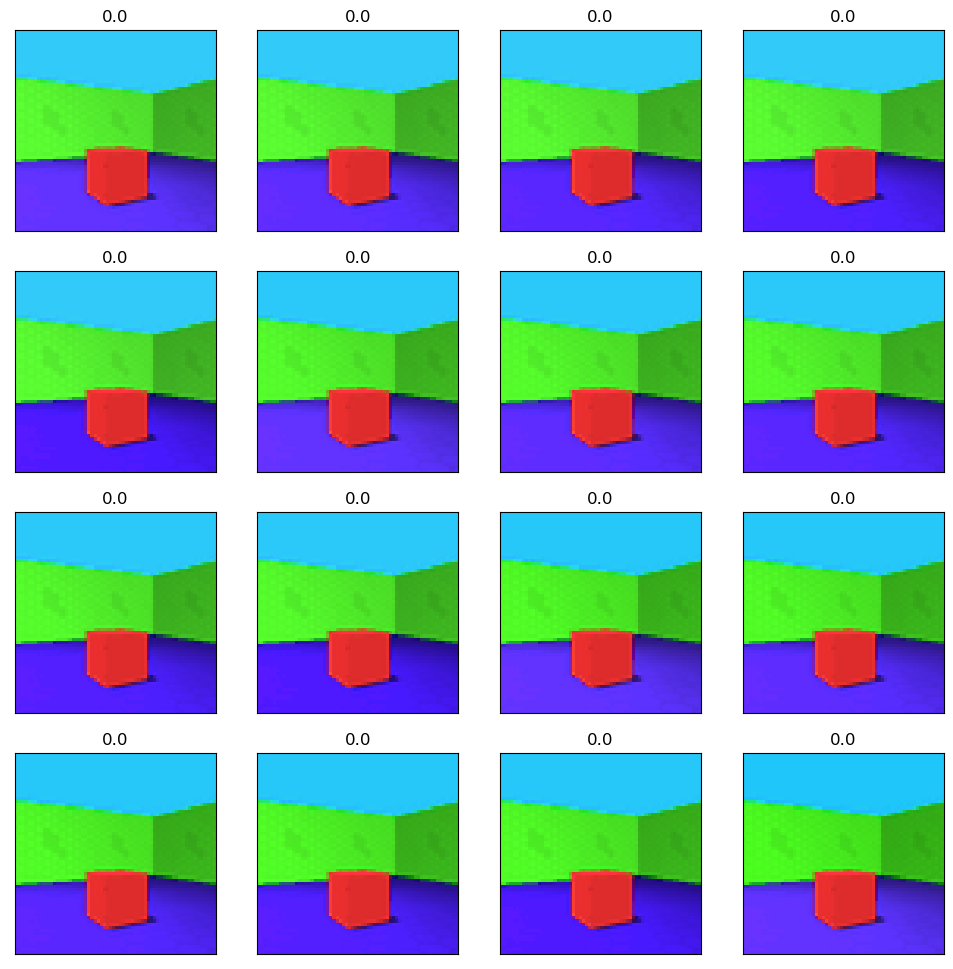

In [3]:
# Initialise number of base images
num_bases = len(images)
# Initialise fragmentation of saturation shift
num_shift = 5
# Training images and labels array
images_test_1 = np.zeros(shape=(num_bases*num_shift*num_shift*num_shift, 64, 64, 3), dtype=np.uint8)
labels_test_1 = np.zeros(shape=num_bases*num_shift*num_shift*num_shift, dtype=np.float64)
# Set iteration index
idx = 0
# Lop over base images and shift saturation globally
for i in tqdm(range(num_bases)):
    for j_object in range(num_shift):
        for j_wall in range(num_shift):
            for j_floor in range(num_shift):
                # Load target image
                target_image = images[i, :, :, :]
                # Load target label
                target_label = labels[i]
                # Convert image from RGB color space to BGR color space
                target_image = cv2.cvtColor(target_image, cv2.COLOR_RGB2BGR)
                # Convert image from BGR color space to HLS color space
                target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2HSV)
                # Split HSV representation into HSV channels
                h, s, v = cv2.split(target_image)

                # Create red mask on object
                mask_object_1 = cv2.inRange(target_image, np.array([0/2, 0, 0]), np.array([40/2, 255, 255]))
                mask_object_2 = cv2.inRange(target_image, np.array([310/2, 0, 0]), np.array([360/2, 255, 255]))
                # Change value of saturation channel for red object
                s[mask_object_1==255] = np.uint8((0.8 + 0.2/(2*(num_shift-1))*j_object)*255)
                s[mask_object_2==255] = np.uint8((0.8 + 0.2/(2*(num_shift-1))*j_object)*255)
                # Create green mask on wall
                mask_wall = cv2.inRange(target_image, np.array([70/2, 0, 0]), np.array([200/2, 255, 255]))
                # Change value of saturation channel for red object
                s[mask_wall==255] = np.uint8((0.8 + 0.2/(2*(num_shift-1))*j_wall)*255)
                # Create blue mask on floor
                mask_floor = cv2.inRange(target_image, np.array([220/2, 0, 0]), np.array([280/2, 255, 255]))
                # Change value of saturation channel for red object
                s[mask_floor==255] = np.uint8((0.8 + 0.2/(2*(num_shift-1))*j_floor)*255)

                # Merge HSV back into target image
                target_image = cv2.merge([h, s, v])
                # Convert image from HLS color space to RGB color space
                target_image = cv2.cvtColor(target_image, cv2.COLOR_HSV2BGR)
                # Convert image from HLS color space to RGB color space
                target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)
                # Save saturation shifted image
                images_test_1[idx, :, :, :] = target_image
                # Save saturation shifted label
                labels_test_1[idx] = target_label
                # Update index
                idx += 1
# Sanity check datatype
print("Test 1 Images Data Type:", type(images_test_1[0][0][0][0]), images_test_1.shape)
print("Test 1 Labels Data Type:", type(labels_test_1[0]), labels_test_1.shape)
# Visualise saturation shifted images
show_images_grid(images_test_1, labels_test_1, num_samples=num_bases*num_shift*num_shift*num_shift, num_images=16, random=False)
# Save training data
# np.savez("3dshapes_satshifted_HSV_test_1.npz", images=images_test_1, labels=labels_test_1)

Step 3: Process testing data 1 such that floor/wall saturations are equal on the region of $\left[\epsilon, 0.5\right]$ and object saturation on the region of $\left(0.5, 1.0-\epsilon\right]$.

Test set 2 is for local saturation test.

100%|██████████| 480/480 [00:06<00:00, 76.46it/s]


Test 2 Images Data Type: <class 'numpy.uint8'> (60000, 64, 64, 3)
Test 2 Labels Data Type: <class 'numpy.float64'> (60000,)


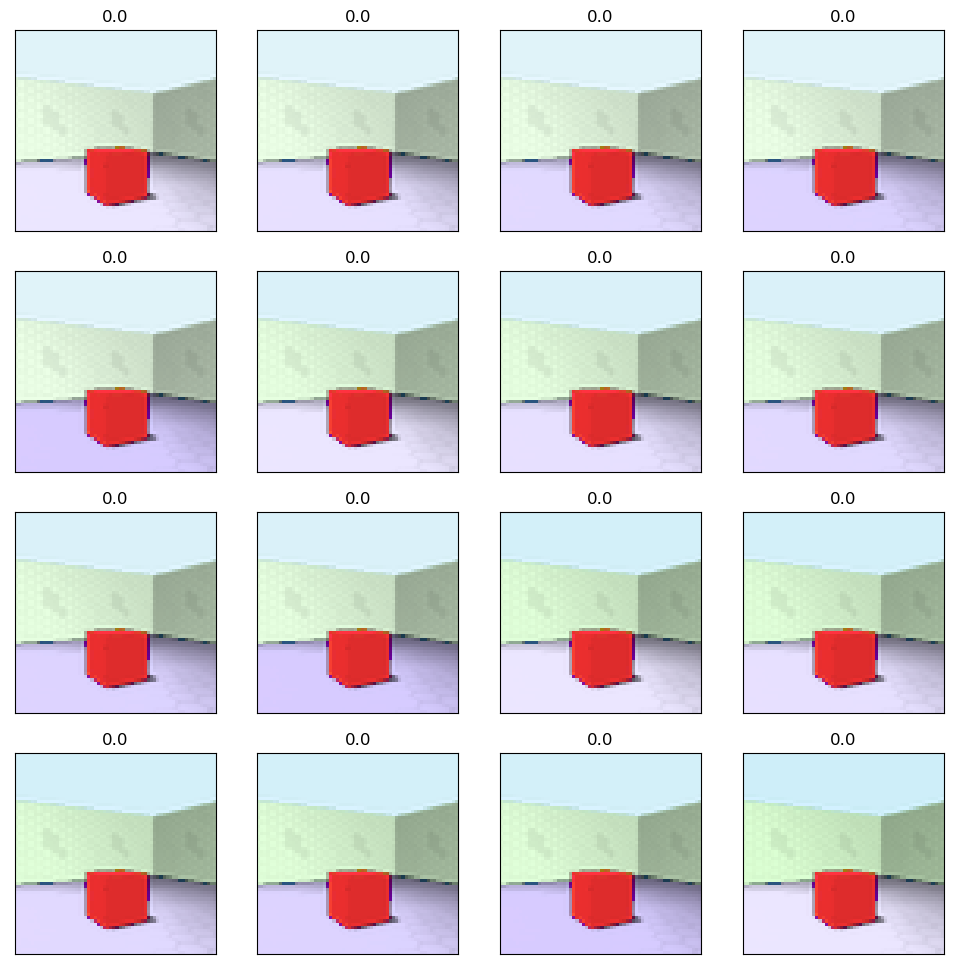

In [4]:
# Initialise number of base images
num_bases = len(images)
# Initialise fragmentation of saturation shift
num_shift = 5
# Training images and labels array
images_test_2 = np.zeros(shape=(num_bases*num_shift*num_shift*num_shift, 64, 64, 3), dtype=np.uint8)
labels_test_2 = np.zeros(shape=num_bases*num_shift*num_shift*num_shift, dtype=np.float64)
# Set iteration index
idx = 0
# Lop over base images and shift saturation globally
for i in tqdm(range(num_bases)):
    for j_object in range(num_shift):
        for j_wall in range(num_shift):
            for j_floor in range(num_shift):
                # Load target image
                target_image = images[i, :, :, :]
                # Load target label
                target_label = labels[i]
                # Convert image from RGB color space to BGR color space
                target_image = cv2.cvtColor(target_image, cv2.COLOR_RGB2BGR)
                # Convert image from BGR color space to HLS color space
                target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2HSV)
                # Split HSV representation into HSV channels
                h, s, v = cv2.split(target_image)

                # Create red mask on object
                mask_object_1 = cv2.inRange(target_image, np.array([0/2, 0, 0]), np.array([40/2, 255, 255]))
                mask_object_2 = cv2.inRange(target_image, np.array([310/2, 0, 0]), np.array([360/2, 255, 255]))
                # Change value of saturation channel for red object
                s[mask_object_1==255] = np.uint8((0.8 + 0.2/(2*(num_shift-1))*j_object)*255)
                s[mask_object_2==255] = np.uint8((0.8 + 0.2/(2*(num_shift-1))*j_object)*255)
                # Create green mask on wall
                mask_wall = cv2.inRange(target_image, np.array([70/2, 0, 0]), np.array([200/2, 255, 255]))
                # Change value of saturation channel for red object
                s[mask_wall==255] = np.uint8((0.1 + 0.2/(2*(num_shift-1))*j_wall)*255)
                # Create blue mask on floor
                mask_floor = cv2.inRange(target_image, np.array([220/2, 0, 0]), np.array([280/2, 255, 255]))
                # Change value of saturation channel for red object
                s[mask_floor==255] = np.uint8((0.1 + 0.2/(2*(num_shift-1))*j_floor)*255)

                # Merge HSV back into target image
                target_image = cv2.merge([h, s, v])
                # Convert image from HLS color space to RGB color space
                target_image = cv2.cvtColor(target_image, cv2.COLOR_HSV2BGR)
                # Convert image from HLS color space to RGB color space
                target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)
                # Save saturation shifted image
                images_test_2[idx, :, :, :] = target_image
                # Save saturation shifted label
                labels_test_2[idx] = target_label
                # Update index
                idx += 1
# Sanity check datatype
print("Test 2 Images Data Type:", type(images_test_2[0][0][0][0]), images_test_2.shape)
print("Test 2 Labels Data Type:", type(labels_test_2[0]), labels_test_2.shape)
# Visualise saturation shifted images
show_images_grid(images_test_2, labels_test_2, num_samples=num_bases*num_shift*num_shift*num_shift, num_images=16, random=False)
# Save training data
# np.savez("3dshapes_satshifted_HSV_test_2.npz", images=images_test_2, labels=labels_test_2)

In [5]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class Shapes3DDataset(Dataset):
    def __init__(self, imgs, labels, transform=None):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        # Access specified image
        sample_data = self.imgs[idx]
        # Cast as PIL Image
        # data = Image.fromarray(sample_data)
        data = sample_data
        # Access specified label
        sample_label = self.labels[idx]
        # Convert label to torch tensor
        label = torch.tensor(sample_label, dtype=torch.long)
        # Transform specified images
        if self.transform:
            data = self.transform(data)
        # Return
        return data, label

In [6]:
import torchvision
import torchvision.transforms as transforms
from hsgroup.transforms import HueSeparation, TensorReshape, HueLuminanceSeparation, RandomScaling

n_groups_hue = 1
n_groups_saturation = 1
transform_train = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        HueSeparation(n_groups_hue) if n_groups_saturation == 1 else HueLuminanceSeparation(n_groups_hue, n_groups_saturation, frac_space=0.25),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        TensorReshape(),
    ]
)
transform_test = transforms.Compose(
    [
        HueSeparation(n_groups_hue) if n_groups_saturation == 1 else HueLuminanceSeparation(n_groups_hue, n_groups_saturation, frac_space=0.25),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        TensorReshape(),
    ]
)

In [7]:
# Load 3D Objects data
train_rawdata = np.load('3dshapes_satshifted_HSV_train.npz')
test1_rawdata = np.load('3dshapes_satshifted_HSV_test_1.npz')
test2_rawdata = np.load('3dshapes_satshifted_HSV_test_2.npz')
# Labels for three sets of data
c1_labels = train_rawdata["labels"]
c2_labels = test1_rawdata["labels"]
c3_labels = test2_rawdata["labels"]
# Images for three sets of data
c1_images = train_rawdata["images"]
c2_images = test1_rawdata["images"]
c3_images = test2_rawdata["images"]
print("laoded")
# Create train set from set c1
c1_dataset = Shapes3DDataset(c1_images, c1_labels, transform=transform_train)
testloader_1 = torch.utils.data.DataLoader(c1_dataset, batch_size=len(c1_images), shuffle=False, num_workers=24)
print("laoded")
# Create test set 2 from set c2
c2_dataset = Shapes3DDataset(c2_images, c2_labels, transform=transform_test)
testloader_2 = torch.utils.data.DataLoader(c2_dataset, batch_size=len(c2_images), shuffle=False, num_workers=24)
print("laoded")
# Create test set 3 from set c2
c3_dataset = Shapes3DDataset(c3_images, c3_labels, transform=transform_test)
testloader_3 = torch.utils.data.DataLoader(c3_dataset, batch_size=len(c3_images), shuffle=False, num_workers=24)
print("laoded")
# Get next iteration
ims_1, lab_1 = next(iter(testloader_1))
print(ims_1.size(), lab_1.size())
ims_2, lab_2 = next(iter(testloader_2))
print(ims_2.size(), lab_2.size())
ims_3, lab_3 = next(iter(testloader_3))
print(ims_3.size(), lab_3.size())

laoded
laoded
laoded
laoded
torch.Size([60000, 3, 64, 64]) torch.Size([60000])
torch.Size([60000, 3, 64, 64]) torch.Size([60000])
torch.Size([60000, 3, 64, 64]) torch.Size([60000])


In [8]:
plt.figure()
ims_1_r = ims_1[:, 0, :, :].cpu().detach().numpy()
ims_1_r = np.reshape(ims_1_r, (60000*64*64))
ims_1_g = ims_1[:, 1, :, :].cpu().detach().numpy()
ims_1_g = np.reshape(ims_1_g, (60000*64*64))
ims_1_b = ims_1[:, 2, :, :].cpu().detach().numpy()
ims_1_b = np.reshape(ims_1_b, (60000*64*64))

plt.figure()
plt.hist(ims_1_r, bins=np.arange(-1.0, 1.0, 0.05), weights=np.ones(len(ims_1_r))/len(ims_1_r), color='firebrick', edgecolor='black')
plt.hist(ims_1_g, bins=np.arange(-1.0, 1.0, 0.05), weights=np.ones(len(ims_1_g))/len(ims_1_g), color='limegreen', edgecolor='black')
plt.hist(ims_1_b, bins=np.arange(-1.0, 1.0, 0.05), weights=np.ones(len(ims_1_b))/len(ims_1_b), color='skyblue', edgecolor='black')

In [ ]:
plt.figure()
ims_2_r = ims_2[:, 0, :, :].cpu().detach().numpy()
ims_2_r = np.reshape(ims_2_r, (60000*64*64))
ims_2_g = ims_2[:, 1, :, :].cpu().detach().numpy()
ims_2_g = np.reshape(ims_2_g, (60000*64*64))
ims_2_b = ims_2[:, 2, :, :].cpu().detach().numpy()
ims_2_b = np.reshape(ims_2_b, (60000*64*64))

plt.figure()
plt.hist(ims_2_r, bins=np.arange(-1.0, 1.0, 0.05), weights=np.ones(len(ims_2_r))/len(ims_2_r), color='firebrick', edgecolor='black')
plt.hist(ims_2_g, bins=np.arange(-1.0, 1.0, 0.05), weights=np.ones(len(ims_2_g))/len(ims_2_g), color='limegreen', edgecolor='black')
plt.hist(ims_2_b, bins=np.arange(-1.0, 1.0, 0.05), weights=np.ones(len(ims_2_b))/len(ims_2_b), color='skyblue', edgecolor='black')

In [ ]:
plt.figure()
ims_3_r = ims_3[:, 0, :, :].cpu().detach().numpy()
ims_3_r = np.reshape(ims_3_r, (60000*64*64))
ims_3_g = ims_3[:, 1, :, :].cpu().detach().numpy()
ims_3_g = np.reshape(ims_3_g, (60000*64*64))
ims_3_b = ims_3[:, 2, :, :].cpu().detach().numpy()
ims_3_b = np.reshape(ims_3_b, (60000*64*64))

plt.figure()
plt.hist(ims_3_r, bins=np.arange(-1.0, 1.0, 0.05), weights=np.ones(len(ims_3_r))/len(ims_3_r), color='firebrick', edgecolor='black')
plt.hist(ims_3_g, bins=np.arange(-1.0, 1.0, 0.05), weights=np.ones(len(ims_3_g))/len(ims_3_g), color='limegreen', edgecolor='black')
plt.hist(ims_3_b, bins=np.arange(-1.0, 1.0, 0.05), weights=np.ones(len(ims_3_b))/len(ims_3_b), color='skyblue', edgecolor='black')